## Python for Time Series Data Analysis
Jose Portilla

<b>[1. Moving Averages](#1)<br></b>
    1.1 Single Exponential Smoothing: EWMA <br>
    1.2 Double/Triple Exponential Smoothing: Holt-Winters Methods<br>
    
<b>[2. Forecasting](#2)<br></b>
    2.1 Holt-Winters<br>
    2.2 Autoregressive Integrated Moving Average - ARIMA(p,d,q)<br>
    2.3 Autoregressive Moving Average - ARMA(p,q)<br>
    2.4 Autoregressive model AR(p)<br>
    2.5 Seasonal Autoregressive Integrated Moving Averages SARIMA(p,d,q)(P,D,Q)m<br>
    2.6 Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX)<br>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats

In [3]:
temps = pd.read_csv('daily-min-temperatures.csv',parse_dates=True,index_col=0)
births = pd.read_csv('daily-total-female-births.csv',parse_dates=True,index_col=0)
passengers = pd.read_csv('airline-passengers.csv',parse_dates=True,index_col=0)
inventories = pd.read_csv('TradeInventories.csv',index_col='Date',parse_dates=True)

### <a id=1> 1. Moving Averages</a>
#### 1.1 Single Exponential Smoothing: EWMA 

Simple Moving Average gives all past data the same and is constricted to one window size. But what if we want recent data to be weighted more than older data cuz it's more reflecting of upcoming future results. Other weaknesses of SMA: 
- Never reaches the peak values due to averaging 
- Lags by the size of the window (1st window size values = NaN)

Solution ==> Exponentially Weighted Moving Average

In [25]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [22]:
#frequency is shown as None for our dataframe we should set it as 'MS': start of the month
print(passengers.index.freq)
passengers.index.freq = 'MS'
print(passengers.index.freq)

None
<MonthBegin>


In [47]:
#1/ Using Pandas
span = 12
alpha = 2/(span+1)

passengers['WMA-12'] = passengers['Passengers'].rolling(12).mean()
passengers['EWMA-12'] = passengers['Passengers'].ewm(span=span,adjust=False).mean()

In [48]:
#2/ Using Statsmodels
model = SimpleExpSmoothing(passengers['Passengers'])
fitted_model = model.fit(smoothing_level=alpha,optimized=False)
passengers['EWMA-12(stats)'] = fitted_model.fittedvalues.shift(-1) 
#depending on the parameter (optimize?) we may need to shift to get the same result as pandas'ewm

C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [49]:
passengers.head(3)

,Passengers,WMA-12,EWMA-12,EWMA-12(stats)
Month,,,,
1949-01-01,112,NaN,112.000000,112.000000
1949-02-01,118,NaN,112.923077,112.923077
1949-03-01,132,NaN,115.857988,115.857988


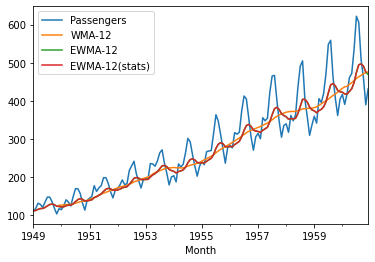

In [50]:
passengers.plot();

#### 1.2 Double/Triple Exponential Smoothing: Holt-Winters Methods

EWMA uses a smoothing factor α which doesn't account for trend and seasonality.
Double smoothing (Holt's method) does not consider seasonality.<br>
Triple smoothing (Holt-Winters's method) considers seasonality.<br>
Holt-Winters divides the time series in 3 components:
- level lt: smoothing parameter α
- trend bt: smoothing parameter β
- seasonality st: smoothing parameter γ



\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

In [5]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [76]:
passengers['DoubleExponentailSmoothing']  = ExponentialSmoothing(passengers['Passengers'],trend='add').fit().fittedvalues.shift(-1)
passengers['TripleExponentailSmoothing']  = ExponentialSmoothing(passengers['Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues #no need for shift here

C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


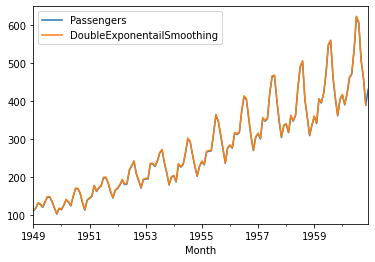

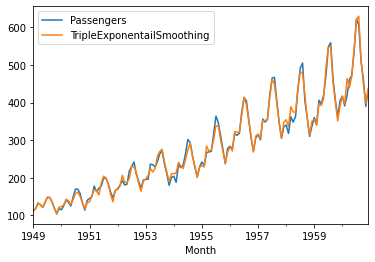

In [83]:
#DoubleExplonentialSmoothing with an additive trend perfectly matches our original data
#it doesn't mean it's the best for forecasting (overfitting)
passengers[['Passengers','DoubleExponentailSmoothing']].plot()
passengers[['Passengers','TripleExponentailSmoothing']].plot();

### ⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷⊷
### <a id=2> 2. Forecasting</a>
#### 2.1 Holt-Winters

Forecasts the variable using a linear combination of a set of level, trend and seasonal predictors.

In [45]:
train_idx = len(passengers) - 36
train = passengers['Passengers'].iloc[:train_idx]
test = passengers['Passengers'].iloc[train_idx:]

model_fitted1 = ExponentialSmoothing(train,trend='mul').fit()
model_fitted2 = ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=12).fit()

#predict 36 periods into the future
#to forecast on data we haven't seen yet we retrain our model on the entire dataset
pred1  = model_fitted1.forecast(36)
pred2  = model_fitted2.forecast(36)

C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


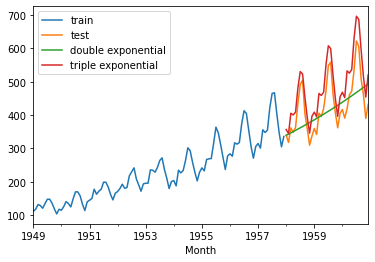

In [46]:
train.plot(label='train')
test.plot(label='test')
pred1.plot(label='double exponential')
pred2.plot(label='triple exponential')
plt.legend();

#### 2.2 Autoregressive Integrated Moving Average - ARIMA(p,d,q)

Used for non-stationary time series that don't have a strong seasonal component.

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

Each component is specified in the model as a parameter:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing. (if linear diff() is enough, if exponential we need more to make the series stationary?)
- q: The size of the moving average window, also called the order of moving average.

Many people want to use ARIMA for predicting the stock market. But the stock market has so many outside factors and information that is not provided with just the timestamp. ARIMA works well with time series where the data is directly related to the timestamp.

Choosing p and q parameters:
   
   1. Method1: Plots (difficult) (check the time series book for more details)
    
     > - Autocorrelation Function (ACF)
     > - Partial Autocorrelation Function (PACF) <br>

     - If the ACF plot shows a positive autocorrelation at the 1st lag (lag-1), then it suggests to use the AR terms in relation to the lag: meaning that if we have a sharp drop in the ACF after lag k, then p = k
     - If the ACF plot shows a gradual decline, we use an MA model instead (no lag component)
     
        
   2. Method2: Grid search (easy but effective): pmdarima (Pyramid ARIMA) library

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima #pip install pmdarima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

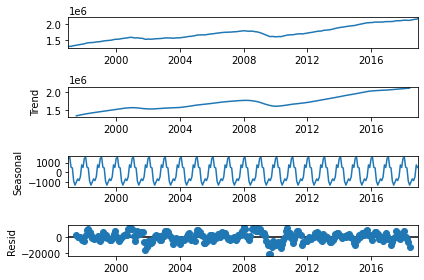

In [8]:
#we choose a dataset with a strong trend component but weak seasonal component
#as we can see below tend ~ observed:
seasonal_decompose(inventories,model='additive').plot();

In [13]:
inventories.head()

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294


In [25]:
#determine the ARIMA orders. It tells us to use SARIMAX(0,1,0)??
auto_arima(inventories,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Sat, 15 Jan 2022   AIC                           5348.037
Time:                        21:17:36   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

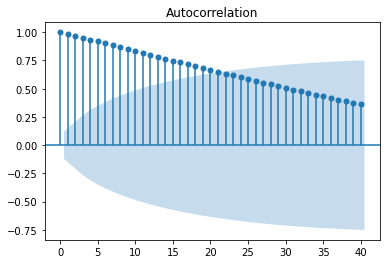

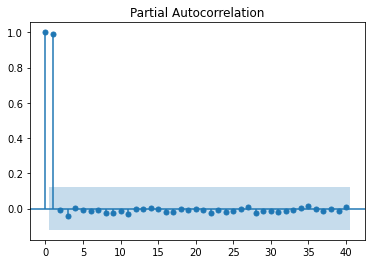

In [21]:
#Let's check with the ACF & PACF: Me no can tell
plot_acf(inventories,lags=40)
plot_pacf(inventories,lags=40);

In [ ]:
inventories.diff()

In [40]:
#Run the Dickery Fuller Test on the 1st difference to check if d = 1 is good
#after one diff, p value drops from 0.95 to 0.01 --> d = 1 is correct
result = adfuller(inventories.diff()[1:])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.412249
p-value: 0.010548
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


In [49]:
train = inventories.iloc[:252]
test = inventories.iloc[252:]

model_fitted = ARIMA(inventories,order=(0,1,0)).fit()
model_fitted.summary()

C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  264
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2703.608
Date:                Sat, 15 Jan 2022   AIC                           5409.217
Time:                        23:12:08   BIC                           5412.789
Sample:                    01-01-1997   HQIC                          5410.652
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.953e+07   4.73e+06     10.481      0.000    4.03e+07    5.88e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -1.15
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

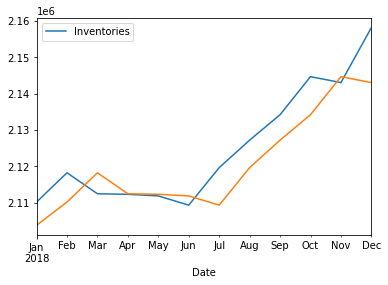

In [50]:
predictions = model_fitted.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels')

test.plot(label='inventories')
predictions.plot(label='predictions');

#### 2.3 Autoregressive Moving Average - ARMA(p,q)

Used for stationary time series. Has no Integrated component (no reason to differentiate because there is no trend)

In [ ]:
from statsmodels.tsa.arima.model import ARMA

#### 2.4 Autoregressive model AR(p)

Forecasts the variable using a linear combination of past values of the variable. The term autoregression describes a regression of the variable against itself. An autoregression is run against a set of lagged values of order  𝑝.

In [55]:
#We can also create lag features and use scikit learn's LinearRegression()??
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

Coefficients = [ 5.84079294e-01  5.90061231e-01 -9.08552623e-02  4.77449509e-02
  4.01494246e-02  3.95818033e-02  2.76018732e-02  4.48114611e-02
  1.38193304e-02  3.86459630e-02 -3.40312953e-04  5.31860952e-03
  1.89005769e-02  2.76027643e-02  1.06525814e-03  2.46541576e-02
  7.60020848e-03  1.12293541e-02  3.55384385e-02 -7.84840519e-03
  2.53893909e-02  2.03398212e-02  1.40560614e-02 -1.66757514e-02
 -3.07569529e-03  3.16140054e-02]
RMSE =  1.1969872100237906


C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


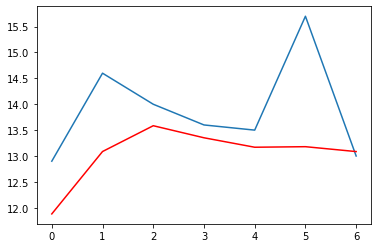

In [56]:
#we want to predict next 7 days min temperature
train = temps.values[1:len(temps)-7]
test = temps.values[len(temps)-7:]

model = AutoReg(train,lags=25) #lag of 25 seems to give a minimum RMSE
model_fit = model.fit()
print('Coefficients =',model_fit.params)

predictions = model_fit.predict(start=len(train),end=len(train)+7-1)
rmse = np.sqrt(mean_squared_error(test,predictions))
print('RMSE = ',rmse)

plt.plot(test)
plt.plot(predictions,color='r');

#### 2.5 Seasonal Autoregressive Integrated Moving Averages SARIMA(p,d,q)(P,D,Q)m

Where ARIMA accepts the parameters  (𝑝,𝑑,𝑞) , SARIMA accepts an additional set of parameters  (𝑃,𝐷,𝑄)𝑚  that specifically describe the seasonal components of the model. Here  𝑃 ,  𝐷  and  𝑄  represent the seasonal regression, differencing and moving average coefficients, and  𝑚  represents the number of data points (rows) in each seasonal cycle.

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
co2 = pd.read_csv('co2_mm_mlo.csv')
co2['date']=pd.to_datetime(dict(year=co2['year'], month=co2['month'], day=1))
co2.set_index('date',inplace=True)
co2.index.freq = 'MS'
co2 = co2[['interpolated']]

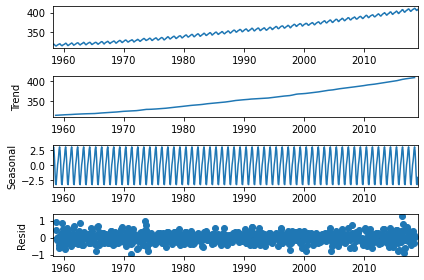

In [15]:
#check the importance of the seasonal component
seasonal_decompose(co2,model='add').plot();

In [16]:
#obtain recommended parameters
#SARIMAX(0, 1, 3)x(1, 0, [1], 12)
auto_arima(co2,seasonal=True,m=12).summary()

C:\Users\oula.aabkari\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,3)(1,0,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\oula.aabkari\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\oula.aabkari\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\oula.aabkari\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\oula.aabkari\Anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\oula.aabkari\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 690, in fit
    mle

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.697
Date:                              Sun, 16 Jan 2022   AIC                            423.394
Time:                                      15:37:38   BIC                            450.936
Sample:                                           0   HQIC                           434.021
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3564      0.036     -9.810      0.000      -0.428      -0.285
ma.L2         -0.0221      0.036     -0.620      0.535      -0.092       0.048
ma.L3         -0.0853      0.035     -2.457      0.014      -0.153      -0.017
ar.S.L12       0.9997      0.000   3338.720      0.000       0.999       1.000
ma.S.L12      -0.8687      0.021    -41.705      0.000      -0.910      -0.828
sigma2         0.0954      0.005     20.369      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.16
Prob(Q):                              0.79   Prob(JB):                         0.12
Heteroskedasticity (H):               1.14   Skew:                             0.00
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
#fit and train the SARIMAX model
train = co2.iloc[:717]
test = co2.iloc[717:]

In [21]:
model_fitted = SARIMAX(train,order=(0,1,3),seasonal_order=(1,0,1,12)).fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.194
Date:                              Sun, 16 Jan 2022   AIC                            414.388
Time:                                      15:38:48   BIC                            441.830
Sample:                                  03-01-1958   HQIC                           424.985
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3542      0.036     -9.868      0.000      -0.425      -0.284
ma.L2         -0.0246      0.037     -0.669      0.503      -0.097       0.047
ma.L3         -0.0869      0.035     -2.513      0.012      -0.155      -0.019
ar.S.L12       0.9996      0.000   2914.529      0.000       0.999       1.000
ma.S.L12      -0.8652      0.023    -38.055      0.000      -0.910      -0.821
sigma2         0.0951      0.005     20.267      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.29
Prob(Q):                              0.78   Prob(JB):                         0.12
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
start=len(train)
end=len(train)+len(test)-1
predictions = model_fitted.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

<AxesSubplot:xlabel='date'>

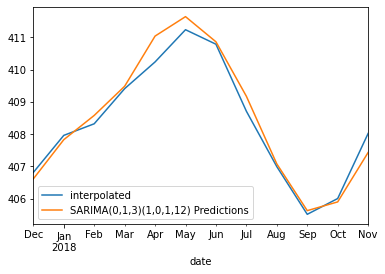

In [25]:
test.plot(legend=True)
predictions.plot(legend=True)

#### 2.6 Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX)
SARIMA but taking into consideration external factors (environmental, economic, etc.) can also influence a time series.

https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html<br>

https://www.statsmodels.org/stable/statespace.html